## How to recognize obstacles inside an image

In [1]:
%matplotlib inline
import cv2
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io
import PIL.Image

## Tool functions 

In [2]:
def show(image):
    # Figure size in inches
    plt.figure(figsize=(15, 15))
    
    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')
    
def show_hsv(hsv):
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    show(rgb)
    
def show_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    show(img)
    
def convex_cnt(image):
    image = image.copy()
    _,contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_ = [cv2.cv2.convexHull(cnt) for cnt in contours ]
    mask = np.zeros(image.shape, np.uint8)
    [cv2.drawContours(mask, [cnt_], -1, 255, -1) for cnt_ in contours_] 
    return contours_,mask

matplotlib.rcParams.update({'font.size': 16})

def show_hsv_hist(image):
    # Hue
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [0], None, [180], [0, 180])
    plt.xlim([0, 180])
    colours = [colors.hsv_to_rgb((i/180, 1, 0.9)) for i in range(0, 180)]
    plt.bar(range(0, 180), np.resize(histr,(180)), color=colours, edgecolor=colours, width=1)
    plt.title('Hue')

    # Saturation
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [1], None, [256], [0, 256])
    plt.xlim([0, 256])

    colours = [colors.hsv_to_rgb((0, i/256, 1)) for i in range(0, 256)]
    plt.bar(range(0, 256), np.resize(histr,(256)), color=colours, edgecolor=colours, width=1)
    plt.title('Saturation')

    # Value
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [2], None, [256], [0, 256])
    plt.xlim([0, 256])
    

    colours = [colors.hsv_to_rgb((0, 1, i/256)) for i in range(0, 256)]
    plt.bar(range(0, 256), np.resize(histr,(256)), color=colours, edgecolor=colours, width=1)
    plt.title('Value')

## Take a picture of the map

In [ ]:
image = skimage.io.imread('pi_map2.jpg')
image = cv2.resize(image, None, fx=1/3, fy=1/3)
print("Dimensiones de la imagen= ", image.shape)
PIL.Image.fromarray(image)

## Visualize RGB format 

In [ ]:
images = []
for i in [0, 1, 2]:
    colour = image.copy()
    if i != 0: colour[:,:,0] = 0
    if i != 1: colour[:,:,1] = 0
    if i != 2: colour[:,:,2] = 0
    images.append(colour)  
show(np.vstack(images))


## Visualize HSV format 

In [ ]:
# Convert from RGB to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
images = []
for i in [0, 1, 2]:
    colour = hsv.copy()
    if i != 0: colour[:,:,0] = 0
    if i != 1: colour[:,:,1] = 255
    if i != 2: colour[:,:,2] = 255
    images.append(colour)
    
hsv_stack = np.vstack(images)
rgb_stack = cv2.cvtColor(hsv_stack, cv2.COLOR_HSV2RGB)
show(rgb_stack)

## Preprocesing the image-map 
Pipelines:
1. GaussianBlur
2. Get the range of values in HSV
 for the obstacles
3. Take only the pixels that match with the ranges into a bit map
4. Clean up the bit map
5. Fill small gaps
6. Remove specks
7. Dilate the mask
8. convexify figures

In [ ]:
# Blur image slightly
image_blur = cv2.GaussianBlur(image, (7, 7), 0)
show(image_blur)

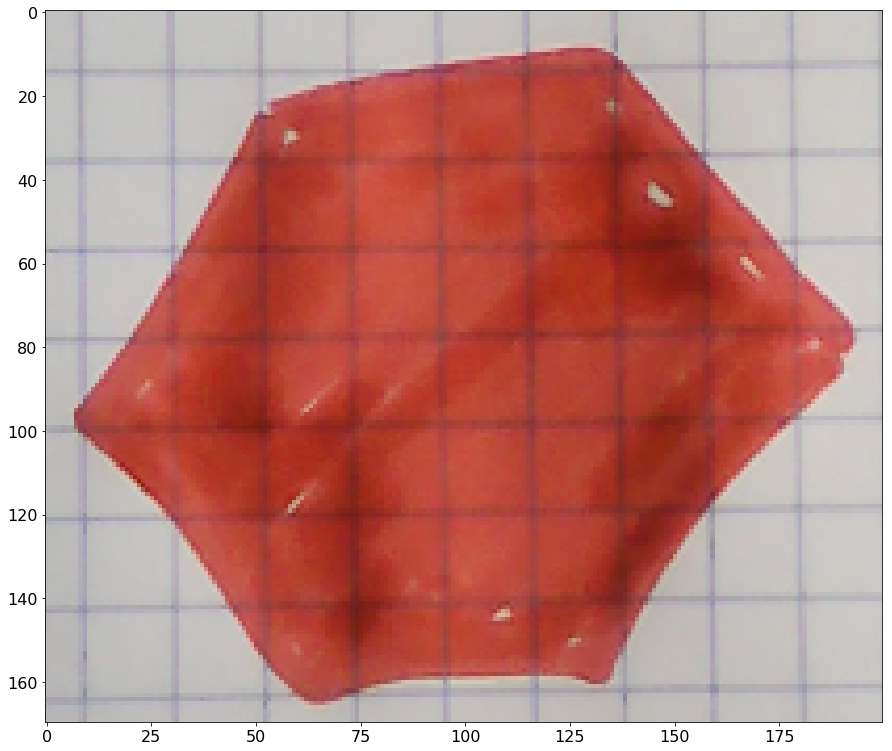

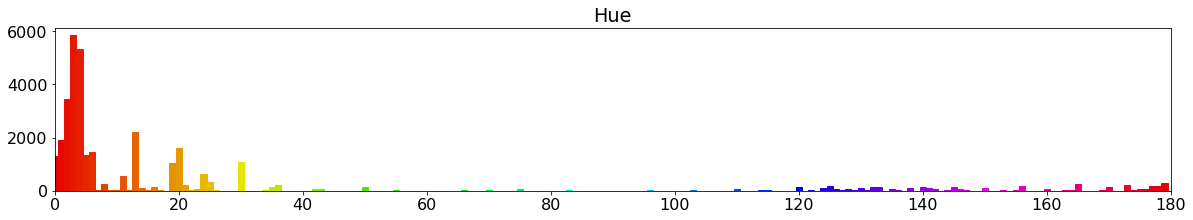

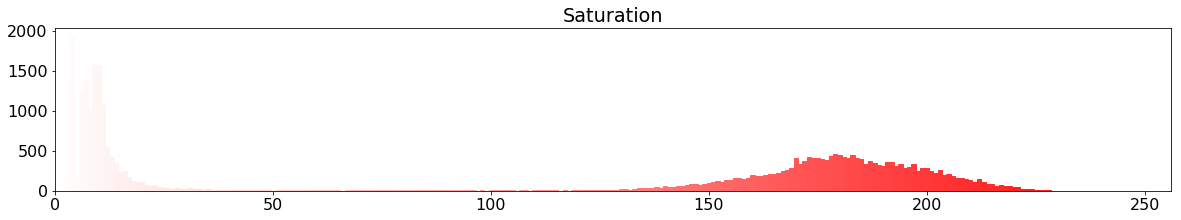

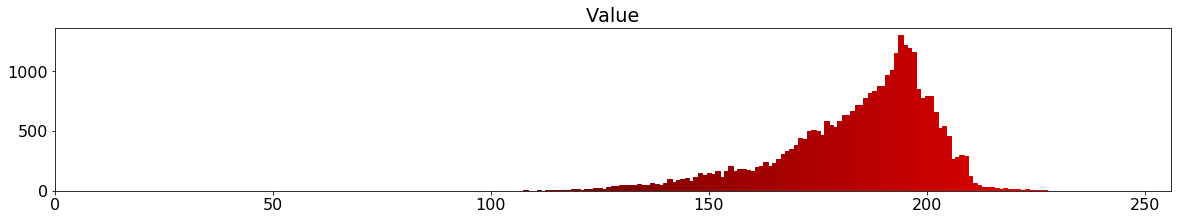

In [7]:
image_cropped = image[380:550,180:380]
show(image_cropped)
image_rect_hsv = cv2.cvtColor(image_cropped, cv2.COLOR_RGB2HSV)
show_hsv_hist(image_rect_hsv)

In [ ]:
image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

# 0-20 hue
min_ = np.array([0, 100, 75])
max_ = np.array([20, 230, 230])
image_bin1 = cv2.inRange(image_blur_hsv, min_, max_)

# 160-180 hue
min_ = np.array([160, 100, 100])
max_ = np.array([180, 230, 230])
image_bin2 = cv2.inRange(image_blur_hsv, min_, max_)

image_bin = image_bin2+image_bin1
show_mask(image_bin)

In [ ]:
# Clean up
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))

# Fill small gaps
image_bin_closed = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel)
#show_mask(image_bin_closed)

# Remove specks
image_bin_closed_then_opened = cv2.morphologyEx(image_bin_closed, cv2.MORPH_OPEN, kernel)
show_mask(image_bin_closed_then_opened)

# Dilate the mask
img = image_bin_closed_then_opened.copy()
kernel1 = np.ones((7,7),np.uint8)
image_dilation = cv2.dilate(img,kernel,iterations = 1)
show_mask(image_dilation)

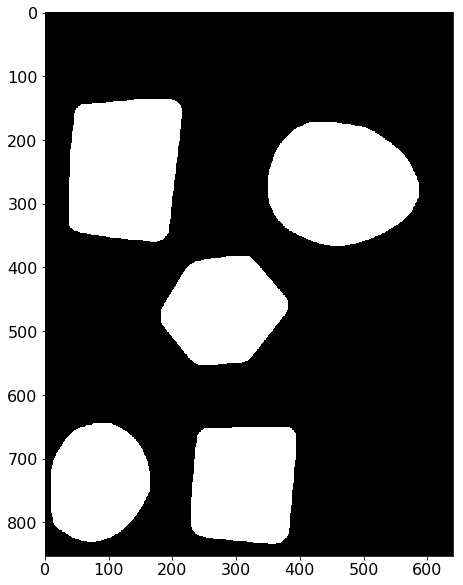

In [10]:
# Convexificando figuras 
contours, mask = convex_cnt(image_dilation)
show_mask(mask)

## Final Image with the obstacles detected overlay

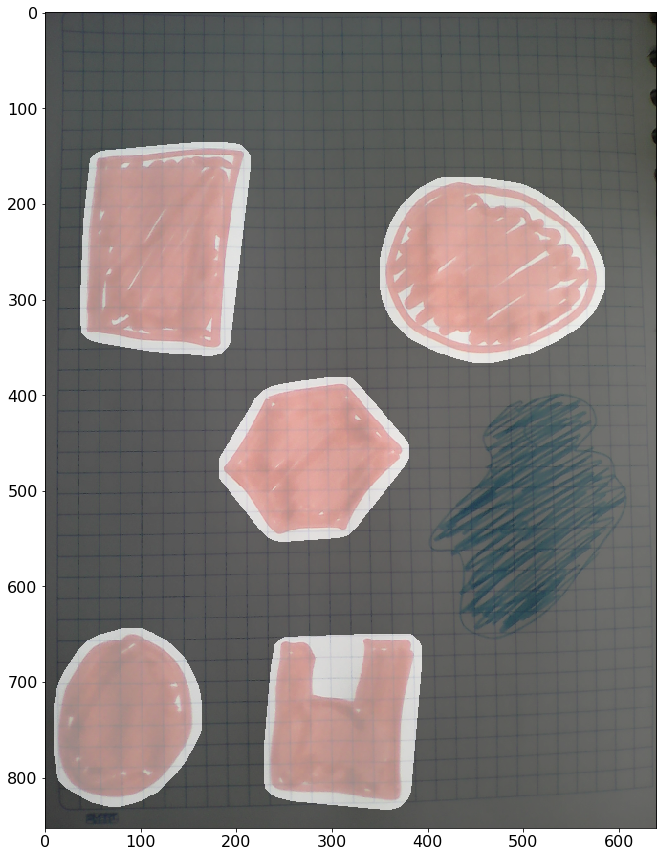

In [11]:
overlay_mask(mask, image)